# <font color="purple"> Coyne - Testing pixel-level colocalization of TDP-43 in P-bodies (DCP1A) between gene groups </font>

- analyzing DCP1A and TDP-43 staining in the same cells from preprocesed tiles
---
- **"Fraction Overlap"** is the pixel-level measure of intereset, using binary masks (ignoring intensities, and looking only on overlap). “Out of all pixels that are ‘on’ in the DCP1A channel (i.e., part of a P-body), what fraction are also ‘on’ in the TDP-43 channel?” That’s a **colocalization as conditional probability P(TDP+|DCP1A+)** — measuring whether TDP-43 signal appears in P-body regions, pixel-by-pixel.
---
- Linear Mixed Models for comparing "Fraction Overlap" between **gene groups**. we expect more overlap in cases vs controls. 
---
- Rotation test to validate differences between gene groups: A channel rotation test simulates the null hypothesis of no spatial alignment between DCP1A and TDP-43 (AKA, channel rotation as a null model). 

- - - Null Hypothesis (H0):
TDP-43 signal is randomly distributed with respect to DCP1A — no specific colocalization.

- - - Alternative Hypothesis (H1):
TDP-43 is enriched in DCP1A-positive pixels (i.e., localized to P-bodies).
---

## <font color="darkpink"> Imports</font>


In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
%matplotlib inline

import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA'
sys.path.insert(1, os.getenv('NOVA_HOME'))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from manuscript.plot_config import PlotConfig
from tools.preprocessing_tools.image_sampling_utils import sample_images_all_markers_all_lines
from tools.channels_colocalization.pixel_colocalization_utils import load_tiles_to_dataframe, set_palette_and_labels_per_group, match_tiles_and_score_fraction_overlap
from cell_profiler.code.cp_effect_size_utils import run_analysis_generate_report, assign_gene_group_Coyne_new, assign_plate_Coyne_new, assign_gene_group_Coyne_old
%load_ext autoreload
%autoreload 2

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA
NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA


In [2]:
color_mapping = PlotConfig().COLOR_MAPPINGS_ALYSSA


def load_tiles_paths_Coyne(input_dir):
    # --- Sample preprocesed tiles
    paths = sample_images_all_markers_all_lines(input_dir_batch=input_dir,
                                                _sample_size_per_markers=100, 
                                                _num_markers=4, 
                                                raw=False, 
                                                all_conds=True, 
                                                rep_count=10, 
                                                cond_count=2, 
                                                exclude_DAPI=True, 
                                                markers_to_include=['DCP1A', 'TDP43'])

    print(f"Total of {len(paths)} site images are sampled (each is a numpy of preprocessed tiles)")
    return paths

## <font color="darkpink"> Old Coyne dataset - Globals and Functions</font>

In [3]:
# AlyssaCoyne
MAIN_DATA_PATH = '/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne'
BATCH = 'batch1' 
path_old_dataset = os.path.join(MAIN_DATA_PATH, BATCH)

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/AlyssaCoyne/channels_colocalization/'

# Font
FONT_PATH = '/home/projects/hornsteinlab/sagyk/anaconda3/envs/nova/fonts/arial.ttf'
from matplotlib import font_manager as fm
import matplotlib
fm.fontManager.addfont(FONT_PATH)
matplotlib.rcParams['font.family'] = 'Arial'

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8
})


# <font color="darkpink"> Step 1: Load all preprocesed tiles from Coyne old</font>

In [4]:

paths = load_tiles_paths_Coyne(input_dir=path_old_dataset)

df = load_tiles_to_dataframe(paths, is_new_Coyne=False)

Total of 420 site images are sampled (each is a numpy of preprocessed tiles)
Created DataFrame of 4559 tiles with metadata.


In [5]:
print(df['cell_line'].unique())

# Fiilter by lines
lines_to_include = ["Controls", "c9orf72ALSPatients", "sALSNegativeCytoTDP43", "sALSPositiveCytoTDP43"]
df = df[df['cell_line'].isin(lines_to_include)]
print(df.shape)


# Add the cell line to patient_id, NOTE!! here the patient_id is "repX", so we HAVE TO add the cell line
df['patient_id'] = df['cell_line']+"_"+df['patient_id']
print(df['patient_id'].unique())

# Important to put the reference group first in order for mixedlm() - has to be Categorical!
df["cell_line"] = pd.Categorical(
    df["cell_line"],
    categories=lines_to_include,
    ordered=True
 )


['Controls' 'c9orf72ALSPatients' 'sALSNegativeCytoTDP43'
 'sALSPositiveCytoTDP43']
(4559, 10)
['Controls_rep5' 'Controls_rep6' 'Controls_rep3' 'Controls_rep2'
 'Controls_rep1' 'Controls_rep4' 'c9orf72ALSPatients_rep3'
 'c9orf72ALSPatients_rep1' 'c9orf72ALSPatients_rep2'
 'sALSNegativeCytoTDP43_rep1' 'sALSNegativeCytoTDP43_rep2'
 'sALSPositiveCytoTDP43_rep7' 'sALSPositiveCytoTDP43_rep5'
 'sALSPositiveCytoTDP43_rep6' 'sALSPositiveCytoTDP43_rep10'
 'sALSPositiveCytoTDP43_rep4' 'sALSPositiveCytoTDP43_rep2'
 'sALSPositiveCytoTDP43_rep3' 'sALSPositiveCytoTDP43_rep1'
 'sALSPositiveCytoTDP43_rep9' 'sALSPositiveCytoTDP43_rep8']


# <font color="darkviolet"> Step 2: Compute fraction_overlap per tile</font>

In [6]:
df_DCP1A = match_tiles_and_score_fraction_overlap(df, 
                                                  tdp43_threshold_method="mean+0.5sd",
                                                  dcp1a_threshold_method="mean+3sd",
                                                  rotated_tdp=False) 



df_DCP1A.shape: (2284, 10), and df_TDP43.shape (2275, 10)
Matching multiplexed tiles and scoreing tiles "fraction_overlap".
Tiles without matched TDP43: 9


## <font color="darkviolet"> Summary statistics - Aggregate by cell line </font>

In [7]:
df_DCP1A.groupby(['cell_line'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()

/tmp/ipykernel_3789046/1345223797.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_DCP1A.groupby(['cell_line'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()


,cell_line,mean,std,count
0,Controls,0.288029,0.178850,702
1,c9orf72ALSPatients,0.350954,0.201166,354
2,sALSNegativeCytoTDP43,0.265362,0.197308,175
3,sALSPositiveCytoTDP43,0.460024,0.246802,1044


## <font color="darkviolet"> Summary statistics - Aggregate by cell line and patient </font>

In [8]:
df_DCP1A.groupby(['patient_id', 'cell_line'], observed=True)['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()


,patient_id,cell_line,mean,std,count
0,Controls_rep1,Controls,0.240339,0.148430,129
1,Controls_rep2,Controls,0.327744,0.193609,124
2,Controls_rep3,Controls,0.306612,0.193332,72
3,Controls_rep4,Controls,0.272076,0.165808,158
4,Controls_rep5,Controls,0.334028,0.184464,140
5,Controls_rep6,Controls,0.237015,0.169343,79
6,c9orf72ALSPatients_rep1,c9orf72ALSPatients,0.335633,0.198137,132
7,c9orf72ALSPatients_rep2,c9orf72ALSPatients,0.366934,0.206064,145
8,c9orf72ALSPatients_rep3,c9orf72ALSPatients,0.347127,0.197305,77
9,sALSNegativeCytoTDP43_rep1,sALSNegativeCytoTDP43,0.275275,0.191286,86


# <font color="darkgreen"> Step 3: Statistical testing via Mixed-effects modeling</font>

### <font color="deeppink"> Statistically model tile-level data while accounting for patient ID</font>
#### <font color="deeppink"> This models gene group (cell_line) as a fixed effect and subject ID as a random effect — accounting for the nested structure of our data (tiles within sites within patients)</font>


In [ ]:
# Drop rows with missing values in required columns
df_clean = df_DCP1A[['fraction_overlap', 'cell_line', 'patient_id']].dropna()
print(f"Removing rows with missing values: {df_clean.shape[0]} out of {df_DCP1A.shape[0]}")

# # Linear Mixed Model

results_df_new_coyne = run_analysis_generate_report(
                                    df=df_clean,
                                    feature_columns=['fraction_overlap'],
                                    group_col="cell_line",
                                    batch_col="patient_id",
                                    output_dir=None,
                                    cov_type="cluster"
                                )
results_df_new_coyne
# model = smf.mixedlm("fraction_overlap ~ cell_line", df_clean, groups=df_clean["patient_id"])
# result_Coyne_old = model.fit(reml=False, disp=False)
# print(result_Coyne_old.summary())



Removing rows with missing values: 2275 out of 2284



Analysing CP feature: fraction_overlap
⚠️ Fallback to fixed-effects model for feature: fraction_overlap with cov_type=cluster
                            OLS Regression Results                            
Dep. Variable:          feature_value   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     25.84
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           4.40e-07
Time:                        00:20:51   Log-Likelihood:                 249.01
No. Observations:                2275   AIC:                            -490.0
Df Residuals:                    2271   BIC:                            -467.1
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             

/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/code/cp_effect_size_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:


,feature,comparison,effect_size,pval,ci_lower,ci_upper,group_var,residual_var,significance,fit_status,used_fixed_model,aic,bic,loglik,r_squared,fdr_pval_global
0,fraction_overlap,Intercept,0.288029,4.679373e-68,0.255645,0.320412,NaN,0.047121,****,fallback_ols_fixed_batch_cov_type+cluster,True,-490.027204,-467.108263,249.013602,0.124125,NaN
1,fraction_overlap,c9orf72ALSPatients,0.062925,8.116326e-04,0.026097,0.099754,NaN,0.047121,***,fallback_ols_fixed_batch_cov_type+cluster,True,-490.027204,-467.108263,249.013602,0.124125,0.001217
2,fraction_overlap,sALSNegativeCytoTDP43,-0.022667,2.071612e-01,-0.057886,0.012553,NaN,0.047121,ns,fallback_ols_fixed_batch_cov_type+cluster,True,-490.027204,-467.108263,249.013602,0.124125,0.207161
3,fraction_overlap,sALSPositiveCytoTDP43,0.171995,1.024209e-05,0.095589,0.248401,NaN,0.047121,****,fallback_ols_fixed_batch_cov_type+cluster,True,-490.027204,-467.108263,249.013602,0.124125,0.000031


# <font color="goldenrod"> Step 4: Channel Rotation Null Test (for validation) </font>
## A channel rotation test simulates the null hypothesis of no spatial alignment between DCP1A and TDP-43.

For each tile:

1. Rotate TDP-43 channel by a 90° angle.
2. Recalculate fraction_overlap_rotated.

In [ ]:
df_DCP1A_rotated = match_tiles_and_score_fraction_overlap(df, 
                                                          tdp43_threshold_method="mean+0.5sd",
                                                          dcp1a_threshold_method="mean+3sd",
                                                          rotated_tdp=True) 

# Drop rows with missing values in required columns
df_DCP1A_rotated_clean = df_DCP1A_rotated[['fraction_overlap', 'cell_line', 'patient_id']].dropna()
print(f"Removing rows with missing values: {df_DCP1A_rotated_clean.shape[0]} out of {df_DCP1A_rotated.shape[0]}")

model_rot = smf.mixedlm("fraction_overlap ~ cell_line", 
                    df_DCP1A_rotated_clean, 
                    groups=df_DCP1A_rotated_clean["patient_id"])

result_rot = model_rot.fit()
print(result_rot.summary())


In [11]:
df_DCP1A_rotated_clean.groupby(['cell_line'], observed=False)['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()

,cell_line,mean,std,count
0,Controls,0.222052,0.165846,702
1,c9orf72ALSPatients,0.213206,0.152588,354
2,sALSNegativeCytoTDP43,0.228531,0.181677,175
3,sALSPositiveCytoTDP43,0.217393,0.153451,1044


In [12]:
# OPTIONAL: Calculate empirical p-values: proportion of rotated values ≥ real value.

# <font color="plum"> Step 5: Visualization - Per-patient values (main analysis) - patient-level means </font>



In [ ]:
def plot(df, result, save_path):
    
    df = df.copy()
    
    group_col = 'cell_line'
    patient_col = 'patient_id'
    
    
    # Get gene-groups (cell lines + patient_id)
    groups = df[group_col].astype(str).unique().tolist() + df[patient_col].astype(str).unique().tolist()
    _palette, label_mapping = set_palette_and_labels_per_group(
        unique_groups=groups, 
        color_mapping_config=color_mapping
    )

    # ------------------------------------- #
    # Change labels of gene-groups (cell lines)
    df[group_col] = df[group_col].cat.rename_categories(label_mapping)
    df[patient_col] = df[patient_col].astype("category").cat.rename_categories(label_mapping)

    # Determine group order and x-axis positions for each group 
    groups_order = sorted(df[group_col].unique(), reverse=False)
    x_spacing = 0.4
    x_pos_map = {label: i * x_spacing for i, label in enumerate(groups_order)}

    # Setup plot
    sns.set(style="white", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(3, 4))
    line_width = 1

    # ============================
    # Plot each group manually by numeric x
    # ============================
    for i, group in enumerate(groups_order):

        group_data = df[df[group_col] == group]
        xpos = x_pos_map[group]

        # Boxplot for group
        sns.boxplot(
            data=group_data,
            y='fraction_overlap',
            hue=group_col, #patient_col,
            ax=ax,
            width=0.3,
            linewidth=line_width,
            showfliers=False,
            showmeans=True,
            meanline=True,
            meanprops={"linestyle": "-", "color": "black", "linewidth": line_width},
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=line_width),
            whiskerprops=dict(linewidth=line_width-0.3, color='black'),
            capprops=dict(linewidth=line_width, color='black'),
            medianprops=dict(visible=False),
            positions=[x_pos_map[group]]
        )

        # ============================
        # Full distribution: raw cell-level/image-level points (light gray)
        # ============================ 
        patient_ids = group_data[patient_col].unique()
        for i, patient in enumerate(patient_ids):
            patient_data = group_data[group_data[patient_col] == patient]

            ax.scatter(
                x=np.random.normal(loc=x_pos_map[group], scale=0.05, size=len(patient_data)),  # jitter
                y=patient_data['fraction_overlap'],
                color=_palette.get(patient, 'black'),#'lightgray',
                s=2,
                alpha=0.1,
                zorder=1
            )

    # ============================
    # Overlay per-patient means (means as colored points)
    # ============================
    patient_means = df.groupby([group_col, patient_col], observed=True)['fraction_overlap'].mean().reset_index()

    for _, row in patient_means.iterrows():
        group = row[group_col]
        patient = row[patient_col]

        # Skip if value is missing
        if pd.isna(group) or pd.isna(patient) or pd.isna(row['fraction_overlap']):
            continue

        xpos = x_pos_map.get(group)
        y = row['fraction_overlap']

        if pd.isna(xpos) or pd.isna(y):
            continue

        jittered_x = np.random.normal(loc=xpos, scale=0.05)

        ax.scatter(
            x=jittered_x,
            y=y,
            color=_palette.get(patient, 'black'),
            edgecolor='none',
            s=25,
            zorder=3,
            label=patient
        )

    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(
        unique.values(),
        unique.keys(),
        title=patient_col,
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    # Set axis formatting
    ax.set_xlim(-x_spacing+0.1, max(x_pos_map.values()) + x_spacing - 0.1)

    ax.set_xticks(list(x_pos_map.values()))
    ax.set_xticklabels(groups_order, rotation=90)
    ax.set_ylabel("Colocalization level \n(TDP-43-P-body fraction overlap)")
    ax.margins(x=0)

    # Ensure tick marks are shown on both axes
    ax.tick_params(axis='both', which='both', direction='out',
                   length=4, width=1, bottom=True, top=False, left=True, right=False)


    # ============================
    # P-value annotation LMM
    # ============================
    xtick_positions = ax.get_xticks()
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    # Overlay effect sizes + p-values if model results are available
    p_values = {}
    if result is not None:
        
        for p, term in zip(result.pvalues, result.params.index):
            match = re.search(r"\[T\.(.*?)\]", term)
            extracted = match.group(1) if match else term
            new_name = label_mapping.get(extracted, extracted)
            # ------------------------- #
            # This is to support both Coyne labels (old and new)
            p_values[new_name] = p
            if new_name in color_mapping:
                p_values[color_mapping[new_name]['alias']] = p
            # ------------------------- #
            

        for xtick_pos, group_label in zip(xtick_positions, xtick_labels):
            
            if group_label == xtick_labels[0]:
                continue  # Skip Intercept (reference)

            p = p_values[group_label]

            # Format p display
            if p < 0.0001:
                p_text = "****"
            elif p < 0.001:
                p_text = "***"
            elif p < 0.01:
                p_text = "**"
            elif p < 0.05:
                p_text = "*"
            else:
                p_text = f"n.s."

            x_keys = list(x_pos_map.values())
            x1, x2 = x_keys[0], xtick_pos
            ymin, ymax = ax.get_ylim()
            buffer = 0.02
            y_range = ymax - ymin
            line_y = ymax - buffer * xtick_pos
            text_y = line_y + 0.01 * y_range

            ax.plot([x1, x1, x2, x2],
            [line_y, line_y + 0.01*y_range, 
             line_y + 0.01*y_range, line_y],
            lw=1.5, c='black')

            ax.text(
                (x1 + xtick_pos)/2,
                text_y,
                p_text,
                ha='center',
                va='bottom',
                fontsize=8,
                color="black")

    # Remove extra space around plot
    plt.tight_layout()
    # Add top space if needed
    #plt.subplots_adjust(top=0.8)
    #plt.suptitle(txt, fontsize=8)

    # Save the plot
    plt.savefig(save_path+"coloc_TDP43_P-bodies_Coyne.pdf", dpi=300, bbox_inches='tight')
    plt.savefig(save_path+"coloc_TDP43_P-bodies_Coyne.png", dpi=300, bbox_inches='tight')
    plt.show()



/tmp/ipykernel_3980492/3536606138.py:191: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


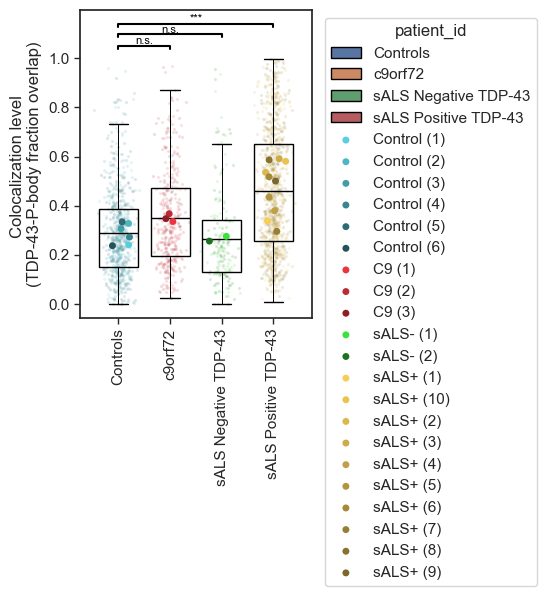

In [14]:
plot(df=df_clean, result=result_Coyne_old, save_path=save_path)


# <font color="red"> ############ ############ ############ ############ </font>



# <font color="darkpink"> New Coyne dataset - Globals and Functions</font>

In [16]:
# AlyssaCoyne
MAIN_DATA_PATH = '/home/projects/hornsteinlab/Collaboration/NOVA/input/images/processed/ManuscriptFinalData_80pct/AlyssaCoyne_new'
BATCH = 'batch1' 
path_new_dataset = os.path.join(MAIN_DATA_PATH, BATCH)

# Save figure at:
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/AlyssaCoyne_new/channels_colocalization/'


## <font color="darkpink"> Step 1: Load all preprocesed tiles from Coyne old</font>

In [17]:

paths = load_tiles_paths_Coyne(input_dir=path_new_dataset)

df = load_tiles_to_dataframe(paths, is_new_Coyne=True)



Total of 240 site images are sampled (each is a numpy of preprocessed tiles)
Created DataFrame of 2783 tiles with metadata.


In [18]:
# Get gene-groups (cell lines)
print(df['cell_line'].unique())
print(df['patient_id'].unique())

# Fiilter by lines
lines_to_include = ['Ctrl', 'C9', 'SALSNegative', 'SALSPositive']
df = df[df['cell_line'].isin(lines_to_include)]
print(df.shape)

# Add the cell line to patient_id
df['patient_id'] = df['cell_line']+"-"+df['patient_id']
print(df['patient_id'].unique())


# Important to put the reference group first in order for mixedlm() - has to be Categorical!
df["cell_line"] = pd.Categorical(
    df["cell_line"],
    categories=lines_to_include,
    ordered=True
 )


# Update gene-groups (cell lines) accordingly 
print(df['cell_line'].unique())
print(df['patient_id'].unique())


['C9' 'Ctrl' 'SALSNegative' 'SALSPositive']
['CS2YNL' 'CS7VCZ' 'CS8RFT' 'EDi022' 'EDi029' 'EDi037' 'CS0ANK' 'CS0JPP'
 'CS6ZU8' 'CS2FN3' 'CS4ZCD' 'CS7TN6']
(2783, 10)
['C9-CS2YNL' 'C9-CS7VCZ' 'C9-CS8RFT' 'Ctrl-EDi022' 'Ctrl-EDi029'
 'Ctrl-EDi037' 'SALSNegative-CS0ANK' 'SALSNegative-CS0JPP'
 'SALSNegative-CS6ZU8' 'SALSPositive-CS2FN3' 'SALSPositive-CS4ZCD'
 'SALSPositive-CS7TN6']
['C9', 'Ctrl', 'SALSNegative', 'SALSPositive']
Categories (4, object): ['Ctrl' < 'C9' < 'SALSNegative' < 'SALSPositive']
['C9-CS2YNL' 'C9-CS7VCZ' 'C9-CS8RFT' 'Ctrl-EDi022' 'Ctrl-EDi029'
 'Ctrl-EDi037' 'SALSNegative-CS0ANK' 'SALSNegative-CS0JPP'
 'SALSNegative-CS6ZU8' 'SALSPositive-CS2FN3' 'SALSPositive-CS4ZCD'
 'SALSPositive-CS7TN6']


# <font color="darkviolet"> Step 2: Compute fraction_overlap per tile</font>

In [19]:
df_DCP1A = match_tiles_and_score_fraction_overlap(df, 
                                                  tdp43_threshold_method="mean+1sd",
                                                  dcp1a_threshold_method="mean+3sd",
                                                  rotated_tdp=False) 

df_DCP1A.shape: (1396, 10), and df_TDP43.shape (1387, 10)
Matching multiplexed tiles and scoreing tiles "fraction_overlap".
Tiles without matched TDP43: 9


## <font color="darkviolet"> Summary statistics - Aggregate by cell line </font>

In [20]:
df_DCP1A.groupby(['cell_line'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()

/tmp/ipykernel_3789046/1345223797.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_DCP1A.groupby(['cell_line'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()


,cell_line,mean,std,count
0,Ctrl,0.128682,0.105136,337
1,C9,0.433569,0.191325,428
2,SALSNegative,0.129938,0.149262,261
3,SALSPositive,0.433384,0.219102,361


## <font color="darkviolet"> Summary statistics - Aggregate by cell line and patient </font>

In [21]:
df_DCP1A.groupby(['patient_id', 'cell_line'], observed=True)['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()


,patient_id,cell_line,mean,std,count
0,C9-CS2YNL,C9,0.399240,0.196763,171
1,C9-CS7VCZ,C9,0.456280,0.188577,122
2,C9-CS8RFT,C9,0.456529,0.181418,135
3,Ctrl-EDi022,Ctrl,0.129516,0.100056,125
4,Ctrl-EDi029,Ctrl,0.130904,0.112406,127
5,Ctrl-EDi037,Ctrl,0.124136,0.102245,85
6,SALSNegative-CS0ANK,SALSNegative,0.104720,0.084598,88
7,SALSNegative-CS0JPP,SALSNegative,0.185131,0.224543,70
8,SALSNegative-CS6ZU8,SALSNegative,0.113975,0.116968,103
9,SALSPositive-CS2FN3,SALSPositive,0.438959,0.200478,144


# <font color="darkgreen"> Step 3: Statistical testing via Mixed-effects modeling</font>

### <font color="deeppink"> Statistically model tile-level data while accounting for patient ID</font>
#### <font color="deeppink"> This models gene group (cell_line) as a fixed effect and subject ID as a random effect — accounting for the nested structure of our data (tiles within sites within patients)</font>


In [23]:
# Drop rows with missing values in required columns
df_clean_Coyne_new = df_DCP1A[['fraction_overlap', 'cell_line', 'patient_id']].dropna()
print(f"Removing rows with missing values: {df_clean_Coyne_new.shape[0]} out of {df_DCP1A.shape[0]}")

results_df_new_coyne = run_analysis_generate_report(
                                    df=df_clean_Coyne_new,
                                    feature_columns=['fraction_overlap'],
                                    group_col="cell_line",
                                    batch_col="patient_id",
                                    output_dir=None,
                                    cov_type="cluster"
                                )
results_df_new_coyne
# Linear Mixed Model
# model_Coyne_new = smf.mixedlm("fraction_overlap ~ cell_line", df_clean_Coyne_new, groups=df_clean_Coyne_new["patient_id"])
# result_Coyne_new = model_Coyne_new.fit(reml=True, method='cg', disp=False)
# print(result_Coyne_new.summary())


Removing rows with missing values: 1387 out of 1396



Analysing CP feature: fraction_overlap
⚠️ Fallback to fixed-effects model for feature: fraction_overlap with cov_type=cluster
                            OLS Regression Results                            
Dep. Variable:          feature_value   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           1.91e-08
Time:                        00:42:58   Log-Likelihood:                 450.38
No. Observations:                1387   AIC:                            -892.8
Df Residuals:                    1383   BIC:                            -871.8
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             

/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/code/cp_effect_size_utils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:


,feature,comparison,effect_size,pval,ci_lower,ci_upper,group_var,residual_var,significance,fit_status,used_fixed_model,aic,bic,loglik,r_squared,fdr_pval_global
0,fraction_overlap,Intercept,0.128682,0.000000e+00,0.125705,0.131660,NaN,0.030672,****,fallback_ols_fixed_batch_cov_type+cluster,True,-892.751349,-871.811755,450.375675,0.426067,NaN
1,fraction_overlap,C9,0.304887,6.118634e-67,0.270315,0.339458,NaN,0.030672,****,fallback_ols_fixed_batch_cov_type+cluster,True,-892.751349,-871.811755,450.375675,0.426067,1.835590e-66
2,fraction_overlap,SALSNegative,0.001256,9.475425e-01,-0.036153,0.038664,NaN,0.030672,ns,fallback_ols_fixed_batch_cov_type+cluster,True,-892.751349,-871.811755,450.375675,0.426067,9.475425e-01
3,fraction_overlap,SALSPositive,0.304701,3.040246e-07,0.188081,0.421321,NaN,0.030672,****,fallback_ols_fixed_batch_cov_type+cluster,True,-892.751349,-871.811755,450.375675,0.426067,4.560369e-07


Removing rows with missing values: 1387 out of 1396
              Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  fraction_overlap
No. Observations:   1387     Method:              REML            
No. Groups:         12       Scale:               0.0272          
Min. group size:    69       Log-Likelihood:      505.3413        
Max. group size:    171      Converged:           Yes             
Mean group size:    115.6                                         
------------------------------------------------------------------
                          Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                 0.128    0.047 2.723 0.006  0.036  0.220
cell_line[T.C9]           0.309    0.066 4.651 0.000  0.179  0.439
cell_line[T.SALSNegative] 0.006    0.067 0.092 0.927 -0.125  0.137
cell_line[T.SALSPositive] 0.340    0.067 5.103 0.000  0.209  0.470
Group Var                

/home/projects/hornsteinlab/Collaboration/NOVA/envs/nova/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# <font color="goldenrod"> Step 4: Channel Rotation Null Test (for validation) </font>
## A channel rotation test simulates the null hypothesis of no spatial alignment between DCP1A and TDP-43.

For each tile:

1. Rotate TDP-43 channel by a 90° angle.
2. Recalculate fraction_overlap_rotated.

In [22]:
df_DCP1A_rotated = match_tiles_and_score_fraction_overlap(df, 
                                                          tdp43_threshold_method="mean+1sd",
                                                          dcp1a_threshold_method="mean+3sd",
                                                          rotated_tdp=True) 

# Drop rows with missing values in required columns
df_DCP1A_rotated_clean = df_DCP1A_rotated[['fraction_overlap', 'cell_line', 'patient_id']].dropna()
print(f"Removing rows with missing values: {df_DCP1A_rotated_clean.shape[0]} out of {df_DCP1A_rotated.shape[0]}")

model_rot = smf.mixedlm("fraction_overlap ~ cell_line", 
                    df_DCP1A_rotated_clean, 
                    groups=df_DCP1A_rotated_clean["patient_id"])

result_rot = model_rot.fit(reml=True, method='cg', disp=False)
print(result_rot.summary())


df_DCP1A.shape: (1396, 10), and df_TDP43.shape (1387, 10)
Note: estimating rotated validation — TDP-43 channel will be rotated 90° left.
Matching multiplexed tiles and scoreing tiles "fraction_overlap".
Tiles without matched TDP43: 9
Removing rows with missing values: 1387 out of 1396
               Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   fraction_overlap
No. Observations:   1387      Method:               REML            
No. Groups:         12        Scale:                0.0116          
Min. group size:    69        Log-Likelihood:       1101.2648       
Max. group size:    171       Converged:            Yes             
Mean group size:    115.6                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.198    0.01

/home/projects/hornsteinlab/Collaboration/NOVA/envs/nova/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## NOTE:
#### The p-value from the LMM is two-sided by default, therefore testing: “Is there any difference in overlap between Real and Rotated (in either direction)?”
#### We are using a rotation test to simulate a null distribution, i.e., what overlap would look like if there were no spatial colocalization. AKA we are actually interested in a one-sided hypothesis: “Is real overlap greater than what would be expected by random spatial alignment?"

####  So if your rotated values are consistently lower than the control, it can still give you a "significant" result, but in the opposite direction than you care about.

❗️The rotated overlap is not fully exchangeable across groups — why?
1. Image structure differs between groups even after rotation:

- TDP-43 puncta density

- Spatial compactness of DCP1A

- Size or abundance of organelles

2. Rotation disrupts spatial alignment, but doesn’t eliminate all structure

- In groups with tighter or more organized signal (e.g., aggregates), rotation may break overlap more than in looser structures

- So rotation may lower overlap more strongly in disease than in control

In [23]:
df_DCP1A_rotated_clean.groupby(['cell_line'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()

/tmp/ipykernel_3980492/3266813855.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_DCP1A_rotated_clean.groupby(['cell_line'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()


,cell_line,mean,std,count
0,Ctrl,0.202090,0.142108,337
1,C9,0.129763,0.074056,428
2,SALSNegative,0.145761,0.140469,261
3,SALSPositive,0.116637,0.075560,361


In [24]:
df_DCP1A_rotated_clean.groupby(['patient_id'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()

,patient_id,mean,std,count
0,C9-CS2YNL,0.126885,0.069701,171
1,C9-CS7VCZ,0.131624,0.077622,122
2,C9-CS8RFT,0.131726,0.076514,135
3,Ctrl-EDi022,0.219349,0.141224,125
4,Ctrl-EDi029,0.215884,0.142283,127
5,Ctrl-EDi037,0.156100,0.134532,85
6,SALSNegative-CS0ANK,0.168955,0.149781,88
7,SALSNegative-CS0JPP,0.117997,0.134978,70
8,SALSNegative-CS6ZU8,0.144814,0.133574,103
9,SALSPositive-CS2FN3,0.119301,0.066694,144


In [25]:
# OPTIONAL: Calculate empirical p-values: proportion of rotated values ≥ real value.

# <font color="plum"> Step 5: Visualization - Per-patient values (main analysis) - patient-level means </font>



/tmp/ipykernel_3980492/3536606138.py:191: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


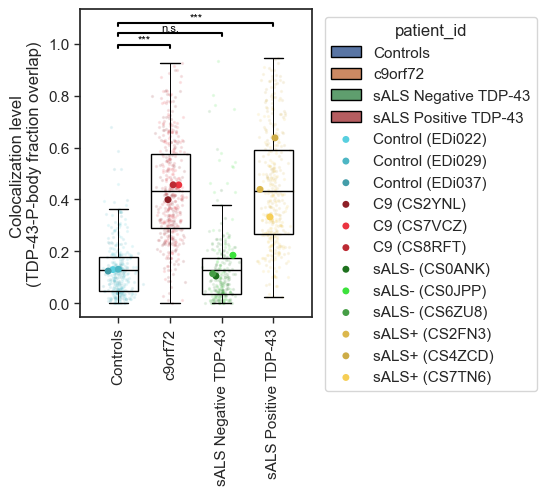

In [26]:
plot(df=df_clean_Coyne_new, result=result_Coyne_new, save_path=save_path)

In [27]:
print("Done!")

Done!
